<a href="https://colab.research.google.com/github/luciaemiliaeu/netflix_data_analysis/blob/main/netflix_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

## Base de dados

In [2]:
url = "https://raw.githubusercontent.com/luciaemiliaeu/netflix_data_analysis/main/ViewingActivity.csv"

In [3]:
dataset = pd.read_csv(url, usecols=['Profile Name', 'Start Time', 'Duration', 'Title', 'Supplemental Video Type'] )

In [4]:
dataset.head()

,Profile Name,Start Time,Duration,Title,Supplemental Video Type
0,Lúcia Emília,2020-11-16 21:09:01,00:20:00,Friends: Temporada 5: Aquele com a garota que ...,NaN
1,Lúcia Emília,2020-11-16 20:46:50,00:22:09,Friends: Temporada 5: Aquele em que todos fica...,NaN
2,Socorro Soares,2020-11-16 20:27:12,00:43:07,Jurassic World: Reino Ameaçado,NaN
3,Lúcia Emília,2020-11-16 20:24:42,00:22:06,Friends: Temporada 5: Aquele com a bolsa do Jo...,NaN
4,Lúcia Emília,2020-11-16 20:02:31,00:22:09,Friends: Temporada 5: Aquele com a risada de t...,NaN


## Pré-processamento

### Filtrando linhas onde o usuário sou eu e o conteúdo é série ou filme.

Isso exclui os outros usuário e conteúdos como trailer.

In [5]:
dataset = dataset[(dataset['Profile Name'] == 'Lúcia Emília') & (dataset['Supplemental Video Type'].isna())]
dataset.drop('Supplemental Video Type', axis=1 , inplace=True)
dataset.reset_index(inplace=True, drop=True)

In [6]:
dataset.drop('Profile Name', axis=1, inplace=True)

### Formatando as colunas de datas

Convertendo para o TimeZone do Brasil

In [7]:
dataset['Start Time'] = pd.DatetimeIndex(pd.to_datetime(dataset['Start Time'], utc=True)).tz_convert('America/Fortaleza')

Criando colunas: 
- *Duration* : duração do acesso em minutos (float)
- *End Time* : horário do término do acesso (datetime)


In [8]:
dataset['Duration'] = pd.to_timedelta(dataset['Duration'])
dataset['End Time'] = dataset['Start Time'] + dataset['Duration']
dataset['Duration'] = dataset['Duration'].apply(lambda x: x.seconds/60)

Criando colunas: 
- *Weekday*: dia da semana (0: Segunda - 6: Domingo)
- *Date* : data (YYYY-mm-dd)
- *Time* : horário (HH:mm:ss)

In [9]:
weekdays = {0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 4: 'Sexta', 5: 'Sábado', 6: 'Domingo'}

In [10]:
dataset['Weekday'] = dataset['Start Time'].dt.dayofweek
dataset['Date'] = dataset['Start Time'].dt.date
dataset['Time'] = dataset['Start Time'].dt.time

In [11]:
dataset = dataset.reindex(['Start Time', 'End Time', 'Duration', 'Date', 'Weekday','Time', 'Title' ], axis=1)

### Filtando episódios realmente assitidos

Cosiderando o tempo mínimo de tela de 5 min por sessão

In [12]:
dataset.drop(dataset[dataset['Duration']<5].index, inplace=True)

### Separando as informações: Título, Temporada e Episódio em colunas 

Case seja filme, as colunas **Temporada** e **Episódio** ficarão com *None*

In [13]:
def identificando_series(title):
  title_, season, episode = None, None, None

  title_braked = title.split(':')
  # se for filme, só vai ter título ou título e subtítulo
  if len(title_braked) == 1 :
    title_ = title_braked[0]
  elif len(title_braked) == 2 :
    title_ = title_braked[0] + title_braked[1]

  # subtítulo no episódio ou no nome da série
  elif len(title_braked) > 3: 
    if ((title_braked[0] == 'Gilmore Girls' and title_braked[1] ==' Tal Mãe, Tal Filha') 
      or (title_braked[0] == 'Gilmore Girls' and title_braked[1] ==' Um Ano para Recordar')
      or (title_braked[0] == 'Stranger Things' and title_braked[1] ==' Stranger Things 2')
      or (title_braked[0] == 'Jo Frost' and title_braked[1] ==' Babá em Turnê')):
      title_ = title_braked[0] + title_braked[1]
      season = title_braked[2]
      episode = title_braked[3]
    else: 
      title_ = title_braked[0]
      season = title_braked[1]
      episode = title_braked[2] + title_braked[3]
    return [title_, season, episode]
  
  else:
    title_ = title_braked[0]
    season = title_braked[1]
    episode = title_braked[2]
  
  return pd.Series([title_, season, episode])

dataset[['Titulo', 'Temporada', 'Episodio']] = dataset.apply(lambda x: identificando_series(x.Title), axis=1 )
dataset.drop('Title', axis=1, inplace=True)

### DataFrame final

In [14]:
dataset.head()

,Start Time,End Time,Duration,Date,Weekday,Time,Titulo,Temporada,Episodio
0,2020-11-16 18:09:01-03:00,2020-11-16 18:29:01-03:00,20.00,2020-11-16,0,18:09:01,Friends,Temporada 5,Aquele com a garota que bate no Joey (Episódi...
1,2020-11-16 17:46:50-03:00,2020-11-16 18:08:59-03:00,22.15,2020-11-16,0,17:46:50,Friends,Temporada 5,Aquele em que todos ficam sabendo (Episódio 14)
2,2020-11-16 17:24:42-03:00,2020-11-16 17:46:48-03:00,22.10,2020-11-16,0,17:24:42,Friends,Temporada 5,Aquele com a bolsa do Joey (Episódio 13)
3,2020-11-16 17:02:31-03:00,2020-11-16 17:24:40-03:00,22.15,2020-11-16,0,17:02:31,Friends,Temporada 5,Aquele com a risada de trabalho do Chandler (...
4,2020-11-16 16:41:01-03:00,2020-11-16 17:02:28-03:00,21.45,2020-11-16,0,16:41:01,Friends,Temporada 5,Aquele com todas as resoluções (Episódio 11)


In [15]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6389 entries, 0 to 8052
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype                            
---  ------      --------------  -----                            
 0   Start Time  6389 non-null   datetime64[ns, America/Fortaleza]
 1   End Time    6389 non-null   datetime64[ns, America/Fortaleza]
 2   Duration    6389 non-null   float64                          
 3   Date        6389 non-null   object                           
 4   Weekday     6389 non-null   int64                            
 5   Time        6389 non-null   object                           
 6   Titulo      6389 non-null   object                           
 7   Temporada   6241 non-null   object                           
 8   Episodio    6241 non-null   object                           
dtypes: datetime64[ns, America/Fortaleza](2), float64(1), int64(1), object(5)
memory usage: 499.1+ KB


## Análises

### Tempo total gasto assistindo Netflix

In [16]:
minutos = dataset['Duration'].sum()
horas = minutos/60
dias = horas/24
print('{} dias {} horas e {} minutos'.format(int(dias), 
                                int(horas)-24*int(dias),
                                int(minutos)-60*(24*int(dias) + (int(horas)-24*int(dias)))
                                ))

116 dias 1 horas e 45 minutos


### Frequência de uso da netflix por data

Contabilizando os minutos assistidos por dia

In [17]:
by_date = dataset.groupby(dataset['Date']).sum()['Duration']

Considerando os dias em que a contagem foi zero.

In [18]:
min_date, max_date = dataset['Date'].min(), dataset['Date'].max()
all_dates = pd.date_range(start = min_date, end = max_date)
dt = pd.Series(data = np.zeros(all_dates.shape[0]), index = all_dates, name = 'Duration' )

In [19]:
dt = pd.merge(dt, by_date, how='left', left_index=True, right_index= True)
dt['Duration'] = dt['Duration_x'] + dt['Duration_y']
dt = (dt.
      drop(['Duration_x', 'Duration_y'], axis=1).
      fillna(0).
      reset_index())
dt['Weekday'] = dt['index'].dt.dayofweek

Formatando os labels do gráfico

In [20]:
dt['labels'] = dt['index'].dt.to_period('M')
index_labels = dt['labels'].searchsorted(dt['labels'].unique())
dt.drop('labels', axis=1, inplace=True)

y = [100,200,300,400,500,600,700,800]
horas = [str(int(x/60)) for x in y]
minutos = [str(int(x%60)) for x in y]
ylabels = list(zip(horas, minutos))
ylabels = [hora[0]+':'+hora[1] for hora in ylabels]

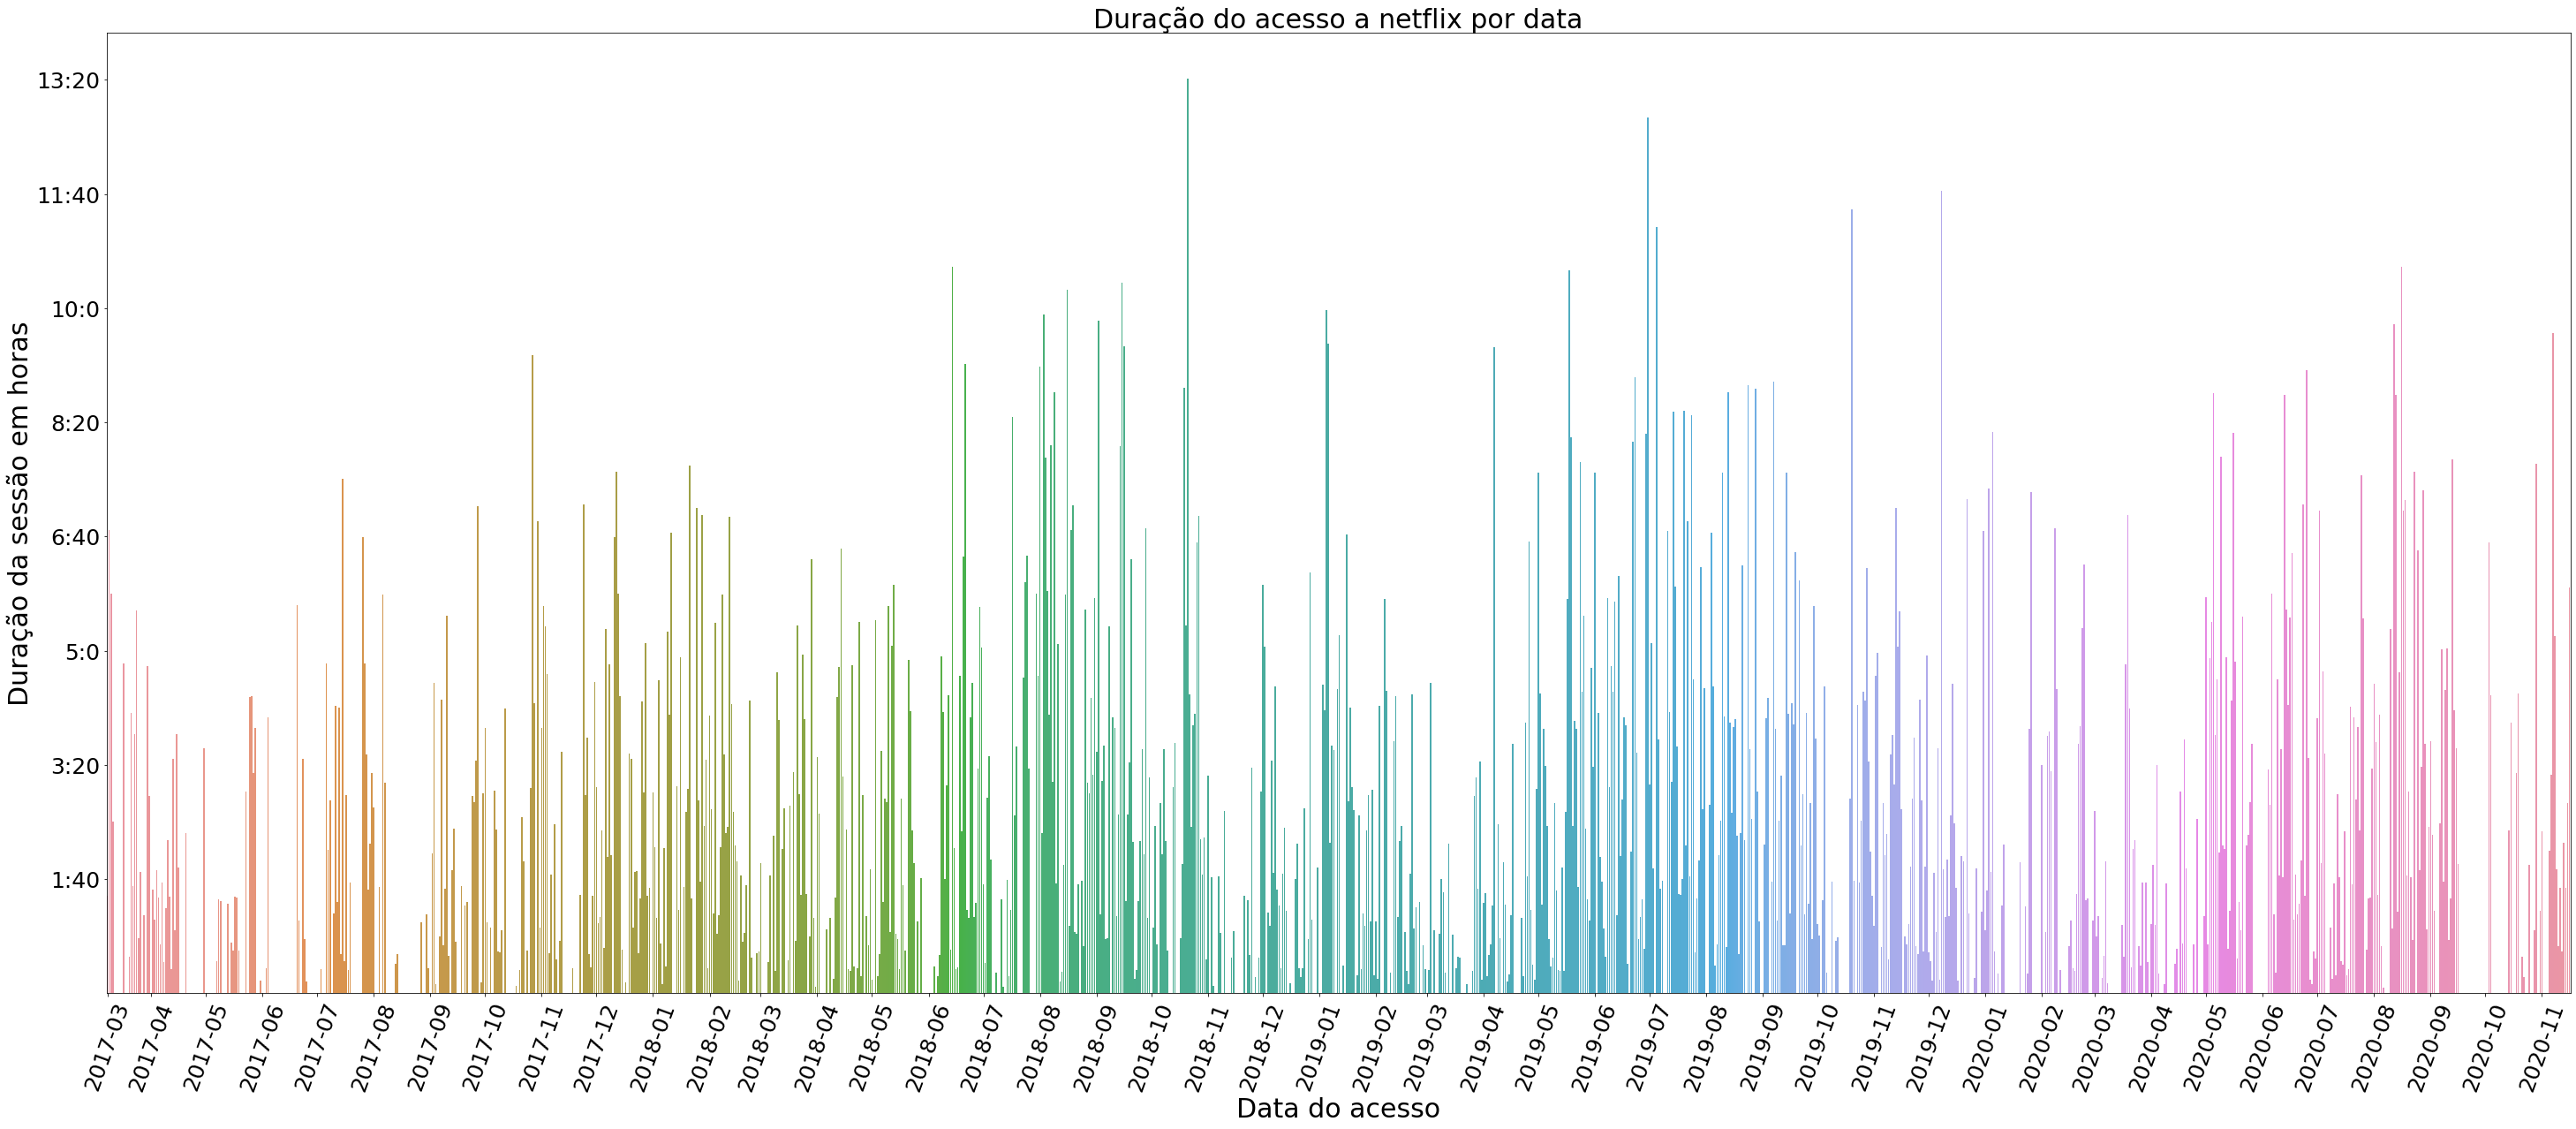

In [21]:
figure = plt.figure(figsize=(50,20))
sns.barplot(x='index', y = 'Duration', data=dt)
plt.xticks(index_labels, dt.loc[index_labels, 'index'].dt.to_period('M'), 
           rotation = 70, fontsize=25)
plt.yticks(y, ylabels, fontsize=25)
plt.xlabel('Data do acesso', fontsize=30)
plt.ylabel('Duração da sessão em horas', fontsize=30)
plt.title('Duração do acesso a netflix por data', fontsize=30)
plt.show()

### Verificando a data do acesso de maior duração

In [22]:
dia_max_acesso = dt[dt['Duration']==dt.max()['Duration']]['index'].dt.date

In [23]:
selected_data = dataset[dataset['Date'].values == dia_max_acesso.values]
selected_data

,Start Time,End Time,Duration,Date,Weekday,Time,Titulo,Temporada,Episodio
4761,2018-10-21 23:40:50-03:00,2018-10-22 00:35:08-03:00,54.300000,2018-10-21,6,23:40:50,Outlander,Temporada 1,A busca (Episódio 14)
4762,2018-10-21 22:44:39-03:00,2018-10-21 23:38:23-03:00,53.733333,2018-10-21,6,22:44:39,Outlander,Temporada 1,A guarda (Episódio 13)
4763,2018-10-21 21:44:20-03:00,2018-10-21 22:38:35-03:00,54.250000,2018-10-21,6,21:44:20,Outlander,Temporada 1,Lallybroch (Episódio 12)
4764,2018-10-21 20:47:57-03:00,2018-10-21 21:44:04-03:00,56.116667,2018-10-21,6,20:47:57,Outlander,Temporada 1,Marca do diabo (Episódio 11)
4766,2018-10-21 19:48:01-03:00,2018-10-21 20:39:50-03:00,51.816667,2018-10-21,6,19:48:01,Outlander,Temporada 1,Meu dedão está coçando (Episódio 10)
4767,2018-10-21 18:52:00-03:00,2018-10-21 19:47:55-03:00,55.916667,2018-10-21,6,18:52:00,Outlander,Temporada 1,A conta (Episódio 9)
4768,2018-10-21 17:58:16-03:00,2018-10-21 18:51:26-03:00,53.166667,2018-10-21,6,17:58:16,Outlander,Temporada 1,Os dois lados (Episódio 8)
4769,2018-10-21 17:03:10-03:00,2018-10-21 17:54:36-03:00,51.433333,2018-10-21,6,17:03:10,Outlander,Temporada 1,Casamento (Episódio 7)
4770,2018-10-21 16:02:06-03:00,2018-10-21 16:56:03-03:00,53.950000,2018-10-21,6,16:02:06,Outlander,Temporada 1,Comandante da tropa (Episódio 6)
4771,2018-10-21 15:05:28-03:00,2018-10-21 16:00:18-03:00,54.833333,2018-10-21,6,15:05:28,Outlander,Temporada 1,Aluguel (Episódio 5)


In [24]:
horas = selected_data.sum()['Duration']/60
min = selected_data.sum()['Duration']%60
print('A sessão mais longa ocorreu no dia', 
      dia_max_acesso.values[0],
      '-{} e foi de {} horas e {} minutos.'.format(weekdays[6], int(horas), int(min)))
print('Foram assistitos {} episódios, 1 de Greys Anatomy e {} da 1º temporada de Outlander.'.format(selected_data.shape[0], selected_data.shape[0]-1))

A sessão mais longa ocorreu no dia 2018-10-21 -Domingo e foi de 13 horas e 21 minutos.
Foram assistitos 16 episódios, 1 de Greys Anatomy e 15 da 1º temporada de Outlander.


### Duração média de acesso

In [25]:
print('A duração média de acesso é de {} horas e {} minutos. '.format(int(dt['Duration'].mean()/60), int(dt['Duration'].mean()%60)))

A duração média de acesso é de 2 horas e 3 minutos. 


### Variação da duração dos acessos de acordo com os dias da semana

In [26]:
by_weekday = dt.groupby('Weekday').mean()

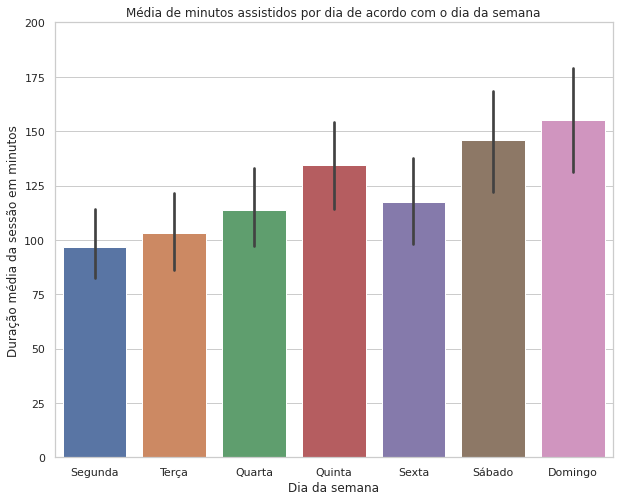

In [27]:
fig = plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.barplot( x='Weekday', y='Duration', data = dt)
plt.ylim(0, 200)
labels = list(map(weekdays.get, by_weekday.index))
plt.xticks(ticks=by_weekday.index , labels=labels)
plt.xlabel('Dia da semana')
plt.ylabel('Duração média da sessão em minutos')
plt.title('Média de minutos assistidos por dia de acordo com o dia da semana')
plt.show()

### Horários de acesso de acordo com a data

Cada acesso é composto por uma data, horário de início, duração e horário de fim. 

Acessos que iniciam em um dia e terminam em outro foram divididos em dois, um para cada dia, terminando o primeiro as 23:59 e iniciando o segundo as 00:00.

In [28]:
data_plot_time = dataset[['Date', 'Start Time', 'End Time']].copy()
data_plot_time['Date End'] = data_plot_time['End Time'].dt.date
data_plot_time['Minute Start'] = (data_plot_time
                                  .apply(lambda x: x['Start Time'].hour*60 + 
                                         x['Start Time'].minute, axis=1))
data_plot_time['Minute End'] = (data_plot_time
                                  .apply(lambda x: x['End Time'].hour*60 + 
                                         x['End Time'].minute, axis=1))

data_plot_time.drop(['Start Time', 'End Time'], axis=1, inplace=True)

def atualiza_datas(x): 
  data_plot_time.loc[x.name] = [x['Date'], x['Date'], x['Minute Start'], 1439]
  data_plot_time.loc[data_plot_time.shape[0]+1] = [x['Date End'], x['Date End'], 0, x['Minute End']]

data_plot_time[data_plot_time['Minute Start'] > data_plot_time['Minute End']].apply(lambda x: atualiza_datas(x), axis=1)

data_plot_time.drop(data_plot_time[data_plot_time['Minute Start'] == data_plot_time['Minute End']].index, inplace=True)
data_plot_time = data_plot_time.sort_values(by=['Date', 'Minute Start', 'Minute End']).reset_index(drop=True)
data_plot_time['Duration'] = data_plot_time['Minute End'] - data_plot_time['Minute Start']

Formatando os labels para plotagem

In [29]:
y = [200,400,600,1000,1200, 1400]
horas = [str(int(x/60)) for x in y]
minutos = [str(int(x%60)) for x in y]
ylabels = list(zip(horas, minutos))
ylabels = [hora[0]+':'+hora[1] for hora in ylabels]

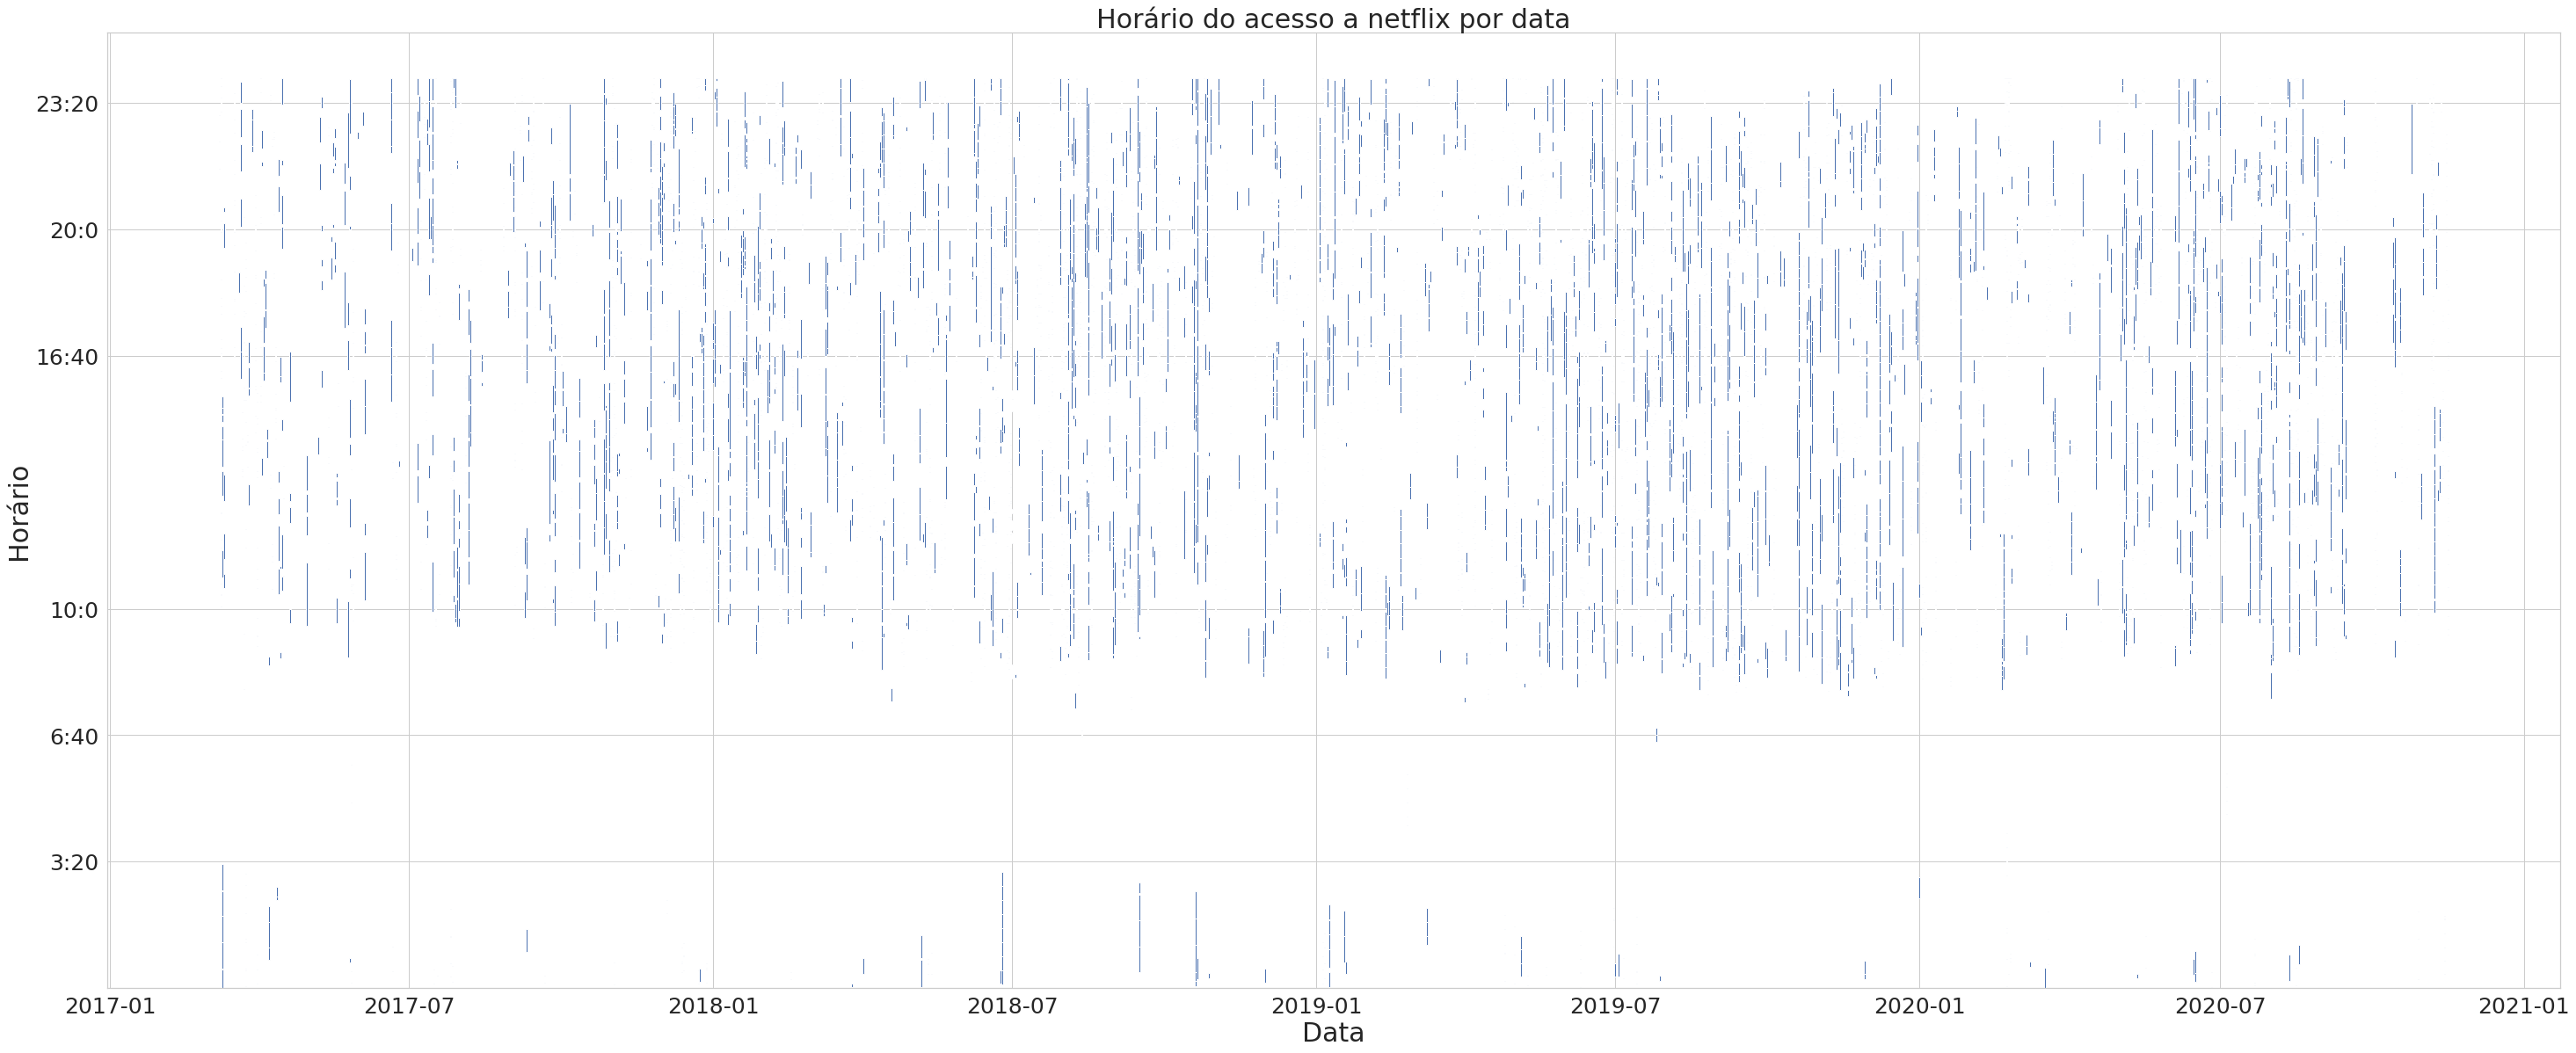

In [30]:
fig = plt.figure(figsize=(50,20))
plt.bar(x = data_plot_time['Date'], 
        height = data_plot_time['Duration'], 
        bottom = data_plot_time['Minute Start'] )
plt.yticks(y, ylabels , fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel('Data', fontsize=30)
plt.ylabel('Horário', fontsize=30)
plt.title('Horário do acesso a netflix por data', fontsize=30)
plt.show()

### Rankeando Séries

#### Com base no número de horas assistidas

In [31]:
series_by_hour = dataset.groupby(['Titulo']).sum()['Duration'].sort_values(ascending=False).head(10)

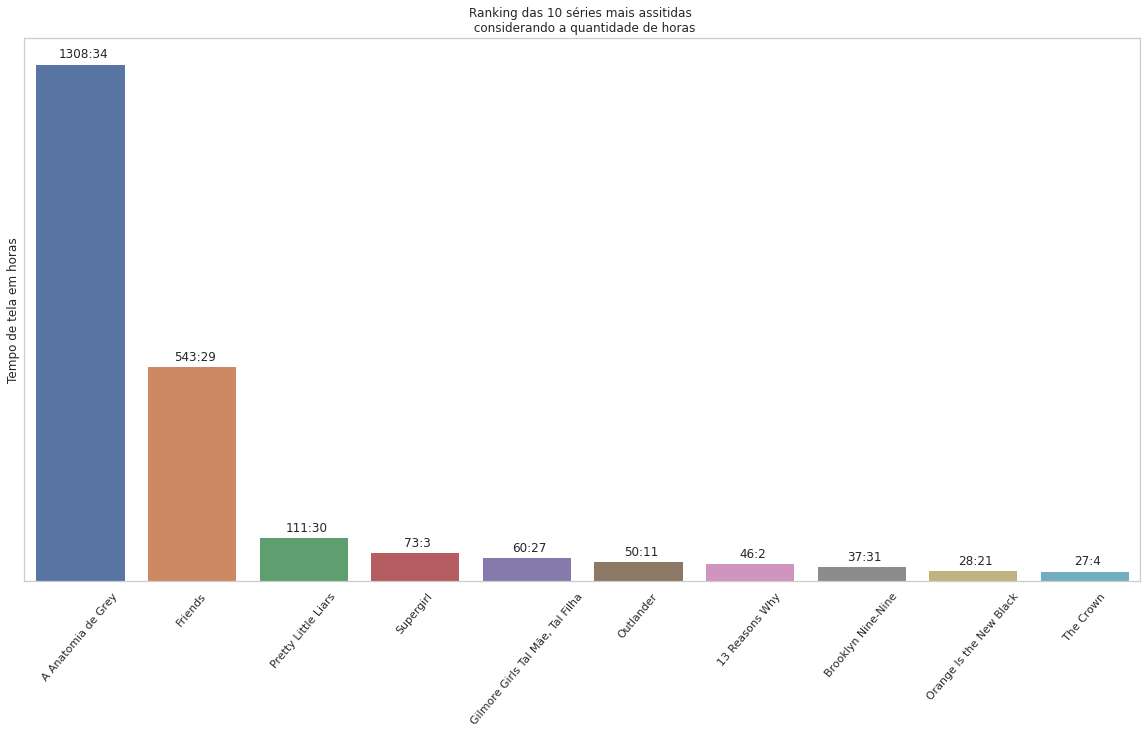

In [32]:
fig = plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
bars = sns.barplot( x=series_by_hour.index, y=series_by_hour.values)
plt.xticks(rotation = 50)
plt.yticks([],[])
plt.xlabel('')
plt.ylabel('Tempo de tela em horas')
plt.title('Ranking das 10 séries mais assitidas \n considerando a quantidade de horas')

for bar in bars.patches:
  height = bar.get_height()
  plt.annotate('{}:{}'.format(int(height/60), int(height%60)),
              xy=(bar.get_x() + bar.get_width() / 2, height),
              xytext=(3, 3),
              textcoords="offset points",
              ha='center', va='bottom')

plt.show()

#### Com base no número de episódios assitidos

In [33]:
series_by_view = dataset.groupby(['Titulo']).count()['Episodio'].sort_values(ascending=False).head(10)

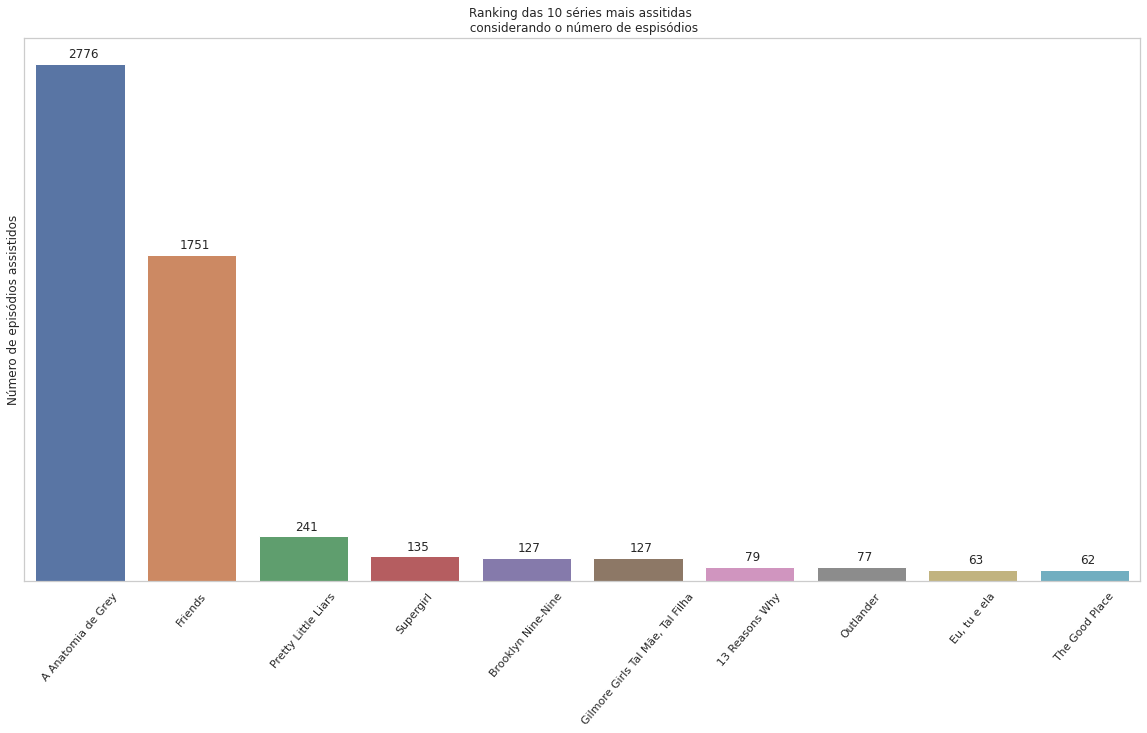

In [34]:
fig = plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
bars = sns.barplot( x=series_by_view.index, y=series_by_view.values)
plt.xticks(rotation = 50)
plt.yticks([],[])
plt.xlabel('')
plt.ylabel('Número de episódios assistidos')
plt.title('Ranking das 10 séries mais assitidas \n considerando o número de espisódios')

for bar in bars.patches:
  height = bar.get_height()
  plt.annotate('{}'.format(int(height)),
              xy=(bar.get_x() + bar.get_width() / 2, height),
              xytext=(3, 3),
              textcoords="offset points",
              ha='center', va='bottom')
  
plt.show()

Episódios mais assistidos

In [35]:
count_viwes = dataset.groupby(['Titulo', 'Temporada', 'Episodio'])['Date'].agg(['count'])
count_viwes.sort_values('count', ascending=False).head(50)

count
Titulo             Temporada     Episodio                                                 
A Anatomia de Grey  Temporada 7   Casamento informal (Episódio 20)                      20
                    Temporada 6   Morte e companhia (Episódio 24)                       17
                    Temporada 8   Disfarçando (Episódio 6)                              17
                                  Tempo ruim (Episódio 22)                              17
                    Temporada 6   Invasão (Episódio 5)                                  16
                                  Festas de fim de ano (Episódio 10)                    16
                                  Bom luto (Episódio 1)                                 16
                    Temporada 10  Quero você comigo (Episódio 2)                        15
                    Temporada 6   Todo mundo quer ser feliz (Episódio 22)               15
                    Temporada 7   Algo tem que dar certo (Episódio 8)                   15
                    Temporada 8   Escura era a noite (Episódio 9)                       15
                    Temporada 7   Esquisitíssimo (Episódio 3)                           15
                    Temporada 8   Entrando no jogo (Episódio 7)                         15
                    Temporada 11  Tem que ser para valer (Episódio 3)                   15
                    Temporada 7   Sou eu tentando (Episódio 7)                          15
                    Temporada 11  O próximo passo (Episódio 9)                          14
                    Temporada 6   Uma questão de ponto de vista (Episódio 6)            14
                                  Obrigação dolorosa (Episódio 4)                       14
                                  Massacre do dia dos namorados (Episódio 14)           14
Friends             Temporada 7   Aquele com a prima da Monica e do Ross (Episód...     14
A Anatomia de Grey  Temporada 9   Monstro adormecido (Episódio 21)                      14
                    Temporada 5   Que diferença um dia faz (Episódio 22)                14
                    Temporada 6   Sem máscaras (Episódio 12)                            14
                    Temporada 12  Quebra de rotina (Episódio 13)                        14
                    Temporada 9   Sentimentos persistentes (Episódio 19)                14
                    Temporada 13  Não é da sua conta (Episódio 12)                      14
                    Temporada 8   De repente (Episódio 10)                              14
                    Temporada 9   Belo apocalipse (Episódio 5)                          13
                    Temporada 6   Cada um por si (Episódio 20)                          13
                    Temporada 8   Só precisamos de amor (Episódio 14)                   13
Friends             Temporada 7   Aquele do vestido de noiva barato (Episódio 17)       13
A Anatomia de Grey  Temporada 9   Mãos ociosas (Episódio 18)                            13
                                  Ela está me matando (Episódio 20)                     13
                    Temporada 13  E só vai piorar (Episódio 13)                         13
                    Temporada 8   Queda livre (Episódio 1)                              13
                                  Migração (Episódio 23)                                13
                                  Amor, perda e legado (Episódio 5)                     13
                    Temporada 7   Desarmar (Episódio 11)                                13
                                  Menor desacompanhada (Episódio 22)                    13
                                  É assim que a gente faz (Episódio 17)                 13
                                  Com você, nasci de novo (Episódio 1)                  13
                                  Chegando a hora (Episódio 15)                         13
                                  Noites em claro, nunca mais (Episódio 9)       

### Friends

In [36]:
friends = dataset[dataset['Titulo']=='Friends'].copy()
friends.loc[:,'Temporada'] = friends.apply(lambda x: x.Temporada.split(' ')[2], axis=1)
friends['episodio'] = friends.apply(lambda x: x.Episodio.split('(')[0], axis=1)
friends['#episodio'] = friends.apply(lambda x: x.Episodio.split('(')[1].split(')')[0].split(' ')[1], axis=1)

In [37]:
ranking_friends = (friends.
                   groupby(['Temporada', '#episodio', 'episodio'])['Duration'].
                   agg(['count']).
                   reset_index().
                   astype({'Temporada': 'int64', '#episodio': 'int64', 'count': 'int64'}).
                   sort_values(by=['Temporada', '#episodio'], ascending=[True, True])
                   )
ranking_friends.reset_index(drop=True, inplace=True)

#### Frequência com que cada episódio foi assistido

In [38]:
labels = ranking_friends[ranking_friends['#episodio']==1]['Temporada']

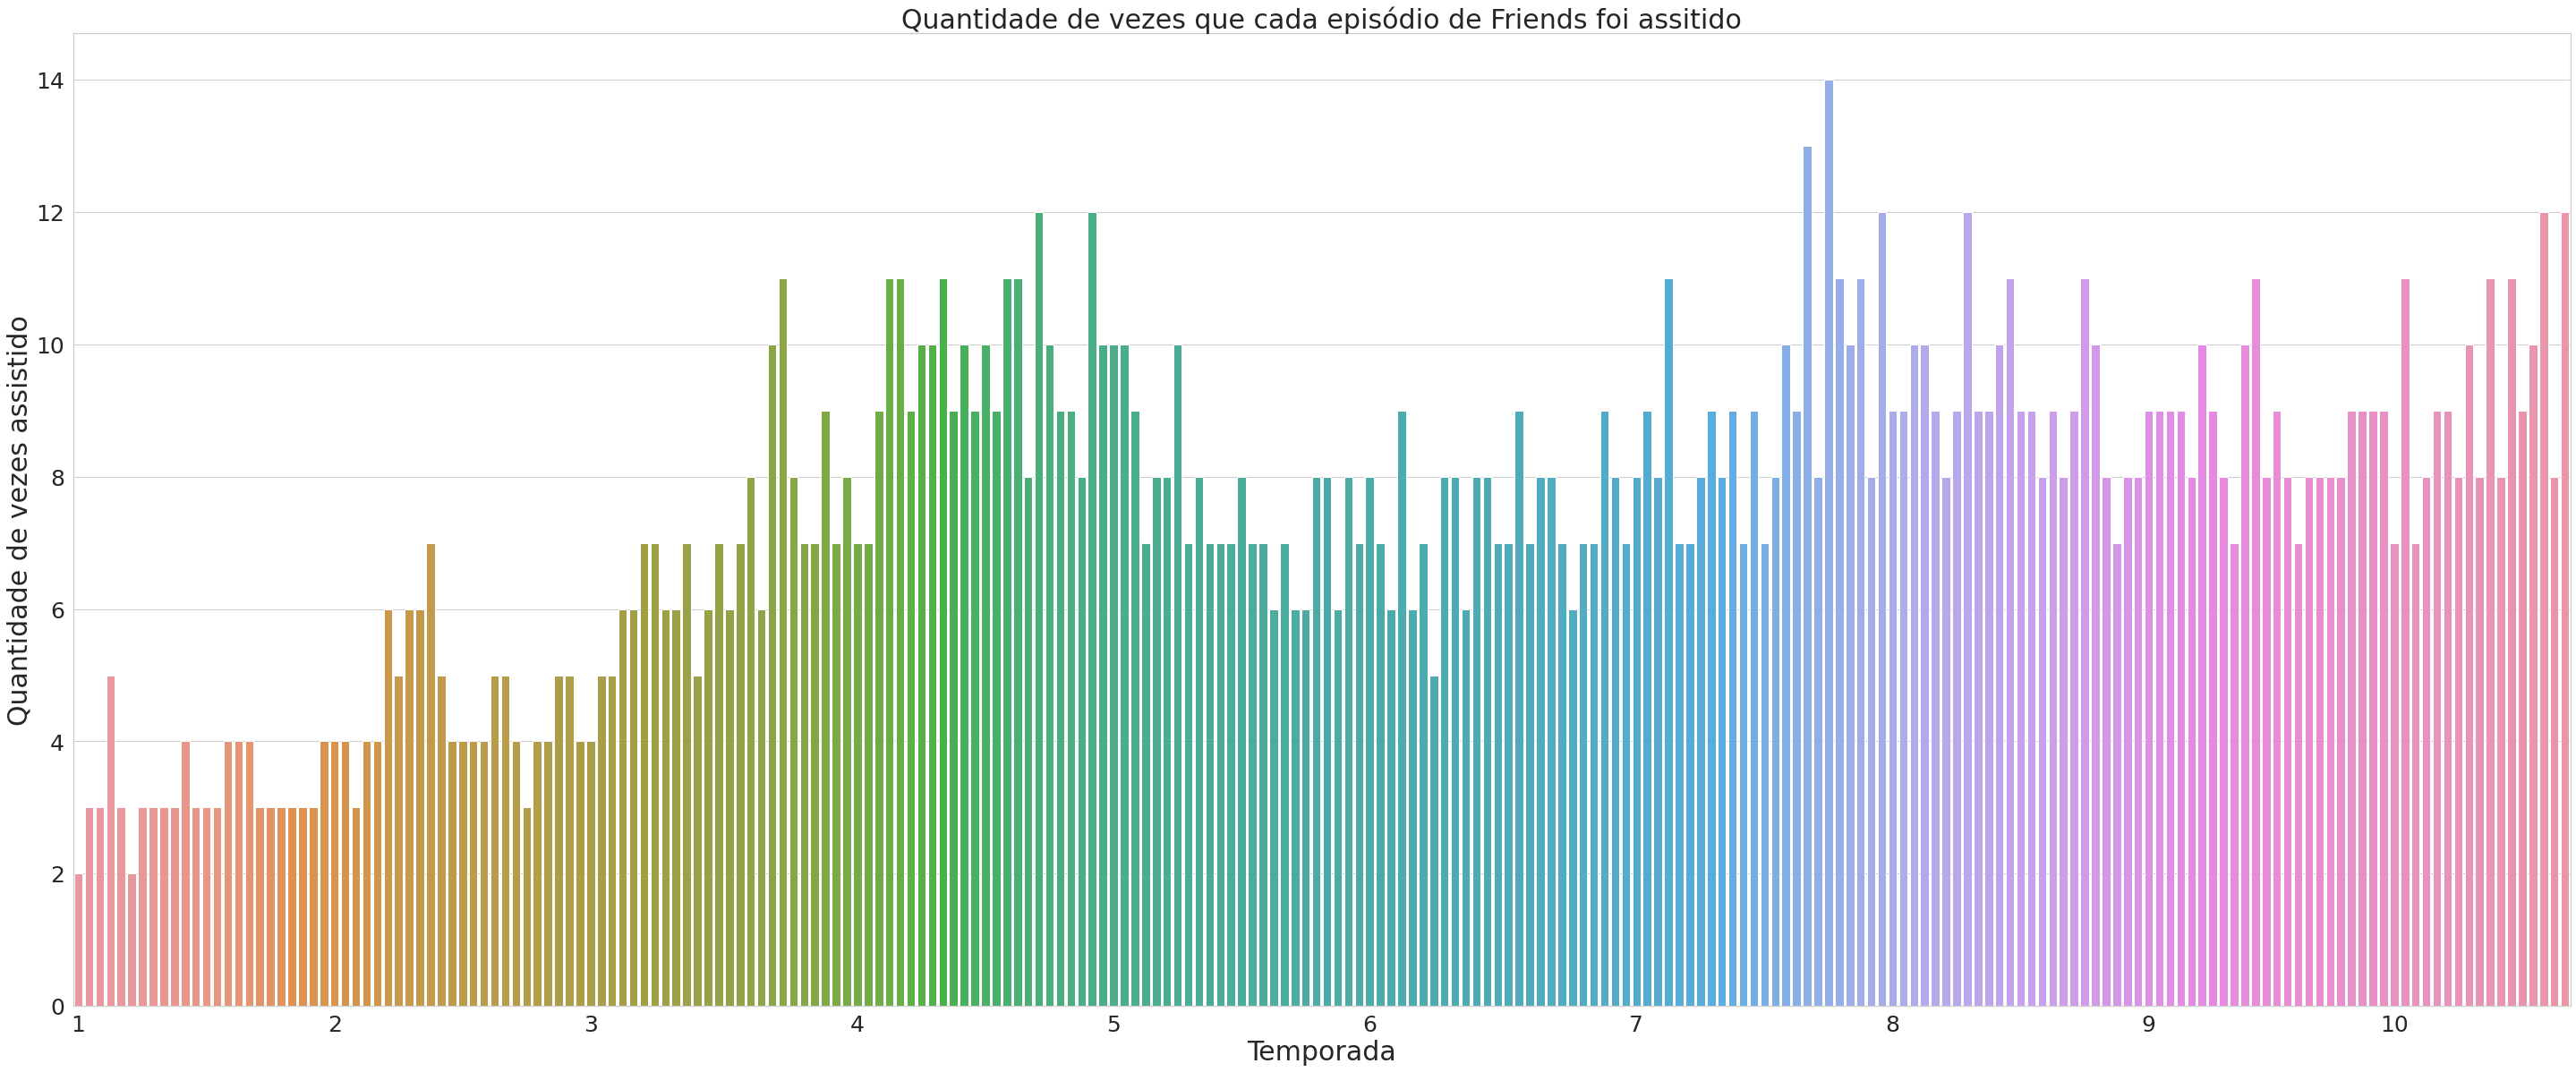

In [39]:
figure = plt.figure(figsize=(50, 20))
sns.barplot(x=ranking_friends.index, 
            y = 'count',
            data=ranking_friends)
plt.xticks(labels.index, labels.values, fontsize= 25)
plt.yticks(fontsize= 25)
plt.xlabel('Temporada', fontsize= 30)
plt.ylabel('Quantidade de vezes assistido', fontsize= 30)
plt.title('Quantidade de vezes que cada episódio de Friends foi assitido', fontsize= 30)
plt.show()

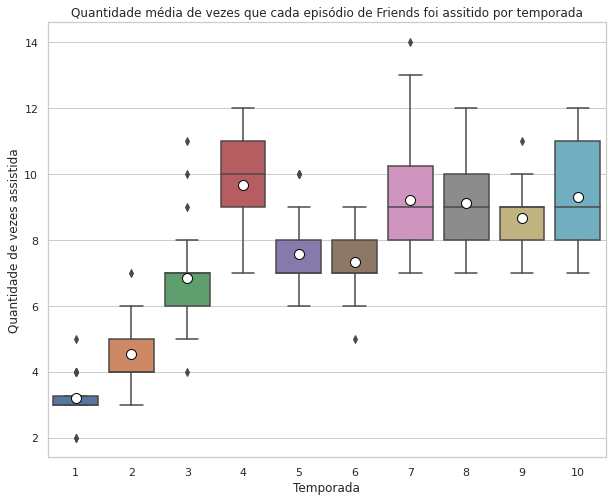

In [40]:
figure = plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.boxplot(x='Temporada', y='count', data = ranking_friends,
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.xlabel('Temporada')
plt.ylabel('Quantidade de vezes assistida')
plt.title('Quantidade média de vezes que cada episódio de Friends foi assitido por temporada')
plt.show()

#### Episódios menos assitidos

In [41]:
ranking_friends[ranking_friends['count']<=3].sort_values(by=['count'])

,Temporada,#episodio,episodio,count
0,1,1,Aquele onde tudo começou,2
5,1,6,Aquele com o traseiro,2
22,1,23,Aquele com o nascimento,3
21,1,22,Aquele do nojinho,3
20,1,21,Aquele com a Monica falsa,3
19,1,20,Aquele com o ortodontista maligno,3
18,1,19,Aquele em que o macaco foge,3
17,1,18,Aquele com o pôquer,3
13,1,14,Aquele dos corações doces,3
12,1,13,Aquele dos seios,3


#### Episódios mais assistidos

In [42]:
ranking_friends[ranking_friends['count']>=10].sort_values(by=['count'], ascending = False)

,Temporada,#episodio,episodio,count
164,7,19,Aquele com a prima da Monica e do Ross,14
162,7,17,Aquele do vestido de noiva barato,13
90,4,18,Aquele do vestido novo da Rachel,12
231,10,15,Aquele em que a Estelle morre,12
177,8,8,Aquele da stripper,12
169,7,24,Aquele com o casamento de Chandler e Monica P...,12
95,4,23,Aquele com o casamento do Ross Parte 1,12
233,10,17,O último episódio Parte 1 e Parte 2,12
149,7,4,Aquele com o assistente da Rachel,11
218,10,2,Aquele em que Ross está legal,11


In [43]:
num_episodios = ranking_friends.shape[0]
ranking_friends['count'].sum()/num_episodios

7.482905982905983

#### Conclusões

Eu assisti a série inteira 2 vezes, ou 3 se desconsiderar os episódios S1E1 e S1E6 (esse problema já está sendo resolvido). 

Se eu tivesse assistido os episódios a mesma quantidade de vezes, teria visto a série 7 vezes. 

Eu tenho preferência pela 4ª temporada e pelas últimas (7-10). Nessas temporadas eu assisti cada episódio mais de 8 vezes.

A primeira e a segunda temporada são as menos assistidas (e olha que eu gosto delas).


### Grey's Anatomy

In [44]:
greys = dataset[dataset['Titulo']=='A Anatomia de Grey'].copy()
greys.loc[:,'Temporada'] = greys.apply(lambda x: x.Temporada.split(' ')[2], axis=1)
greys['episodio'] = greys.apply(lambda x: x.Episodio.split('(')[0], axis=1)
greys['#episodio'] = greys.apply(lambda x: x.Episodio.split('(')[-1].split(')')[0].split(' ')[1], axis=1)

In [45]:
ranking_greys = (greys.
                 groupby(['Temporada', '#episodio', 'episodio'])['Duration'].
                 agg(['count']).
                 reset_index().
                 astype({'Temporada': 'int64', '#episodio': 'int64', 'count': 'int64'}).
                 sort_values(['Temporada', '#episodio'], ascending=[True, True]).
                 reset_index(drop=True)
                 )
ranking_greys

,Temporada,#episodio,episodio,count
0,1,1,"Longa noite, longo dia",2
1,1,2,O primeiro plantão é o mais difícil,2
2,1,3,"Ganhamos a batalha, perdemos a guerra",2
3,1,4,Terra de ninguém,2
4,1,5,É hora da verdade,3
...,...,...,...,...
337,15,21,Ovelha negra,3
338,15,22,De pernas para o ar,5
339,15,23,O que fiz por amor,5
340,15,24,Atraída pelo sangue,3


In [46]:
labels = ranking_greys[ranking_greys['#episodio']==1]['Temporada']

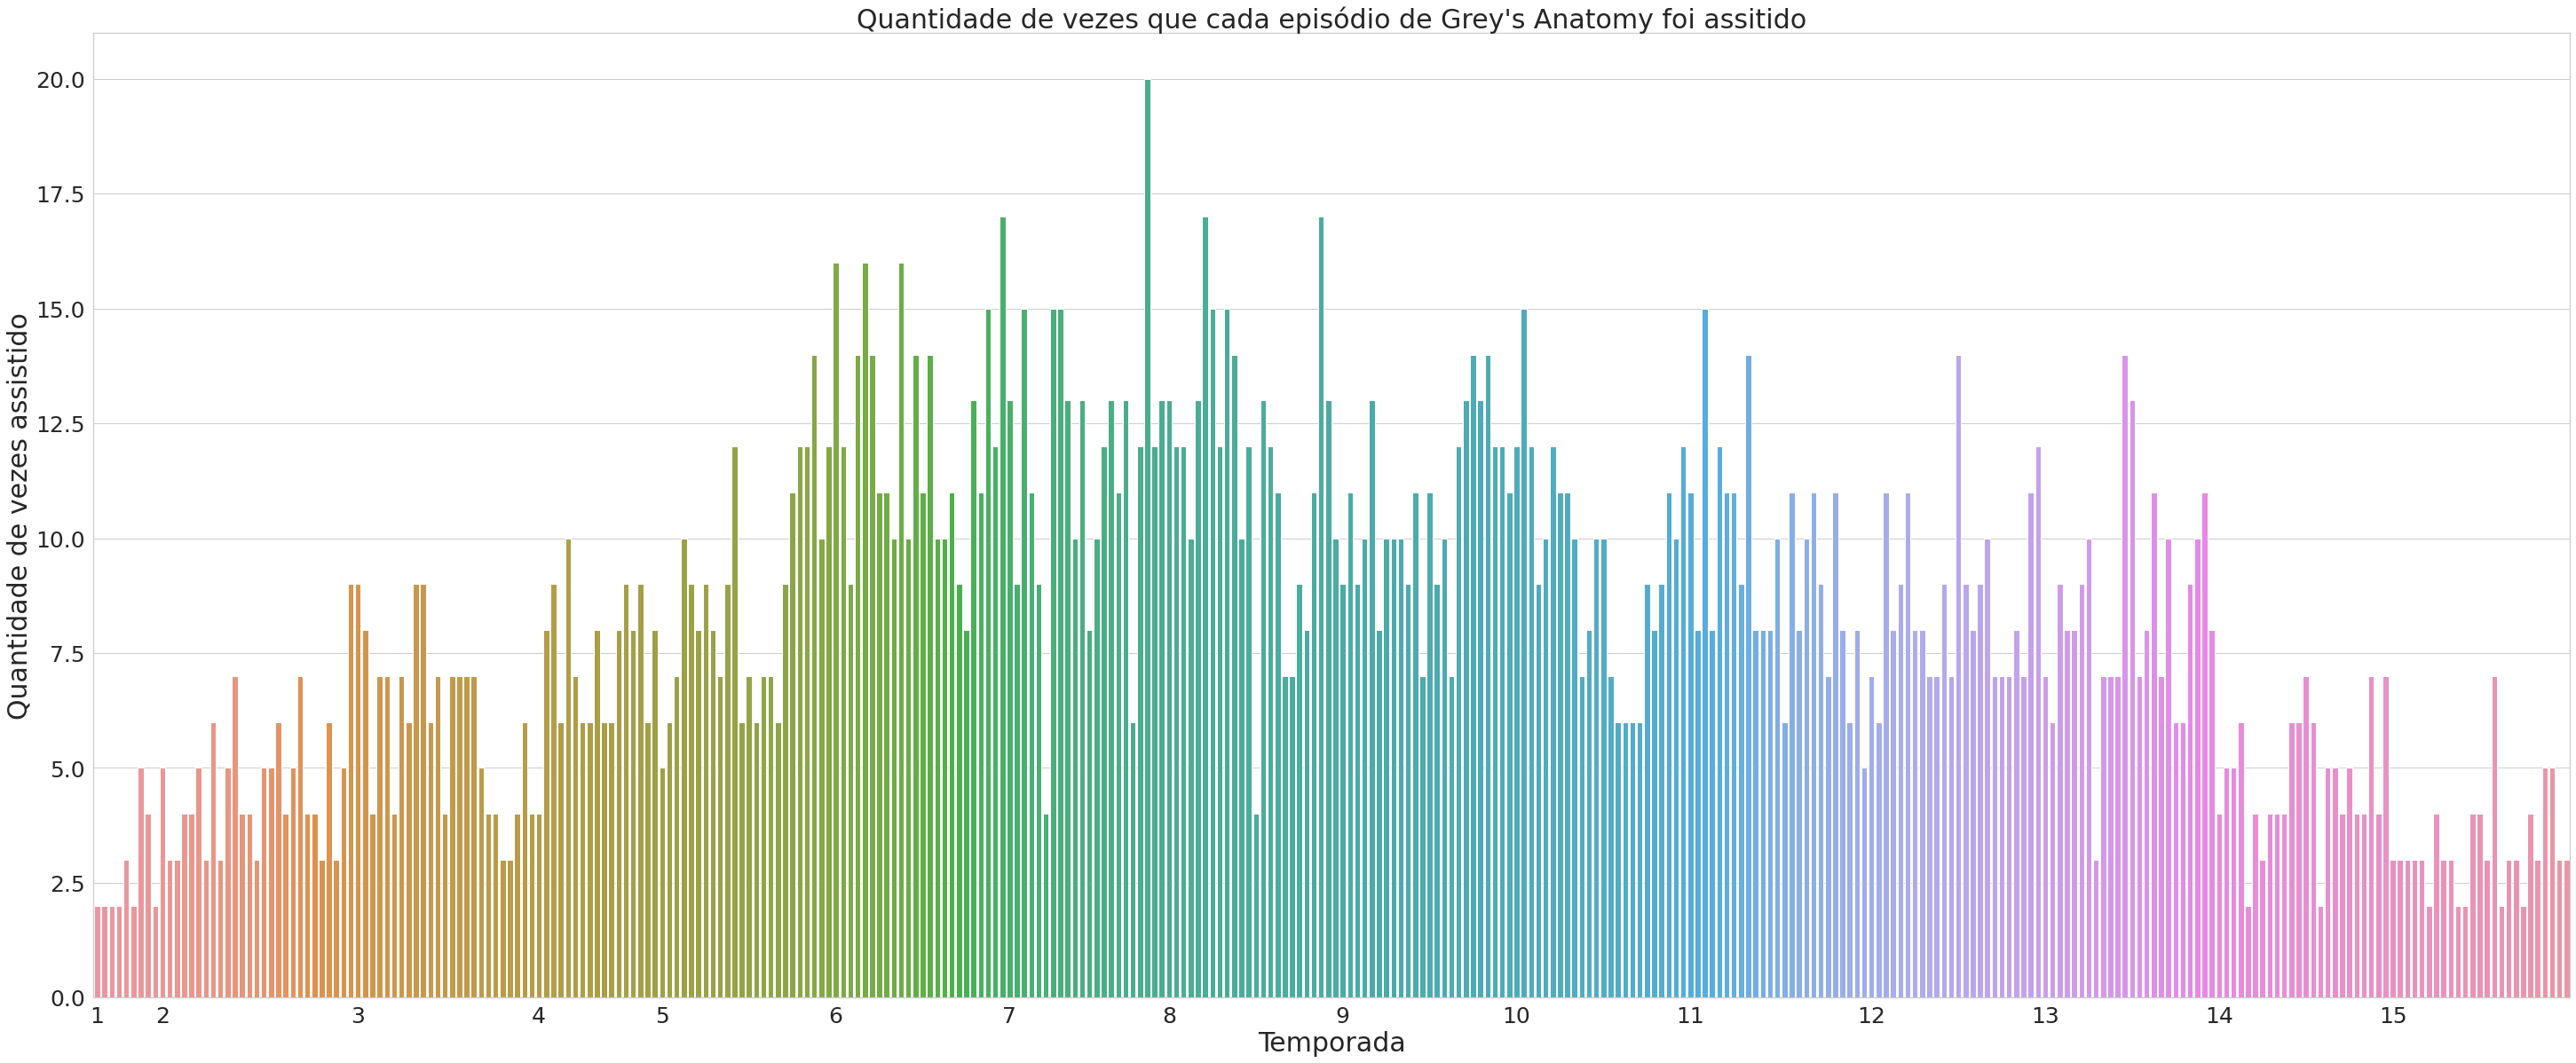

In [47]:
figure = plt.figure(figsize=(50,20))
sns.barplot(x=ranking_greys.index, 
            y = 'count',
            data=ranking_greys)
plt.xticks(labels.index, labels.values, fontsize= 25)
plt.yticks(fontsize= 25)
plt.xlabel('Temporada', fontsize= 30)
plt.ylabel('Quantidade de vezes assistido', fontsize= 30)
plt.title("Quantidade de vezes que cada episódio de Grey's Anatomy foi assitido",
          fontsize= 30)
plt.show()

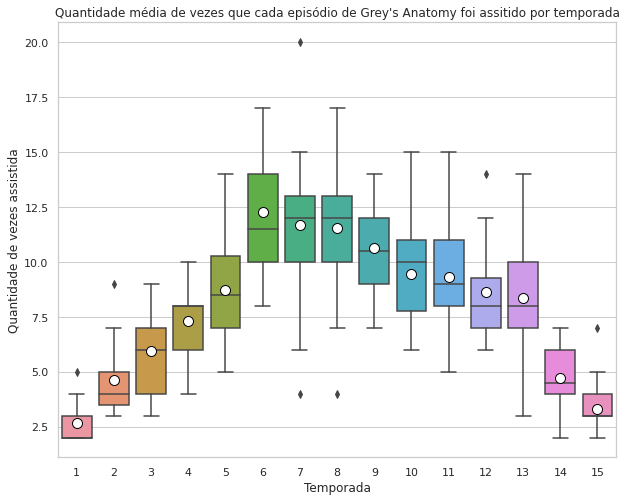

In [48]:
figure = plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.boxplot(x='Temporada', y='count', data = ranking_greys, 
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.xlabel('Temporada')
plt.ylabel('Quantidade de vezes assistida')
plt.title("Quantidade média de vezes que cada episódio de Grey's Anatomy foi assitido por temporada")
plt.show()

#### Episódios menos assitidos

In [49]:
ranking_greys[ranking_greys['count']<=3].sort_values(by=['count'])

,Temporada,#episodio,episodio,count
0,1,1,"Longa noite, longo dia",2
307,14,15,"Velhas cicatrizes, futuros amores",2
297,14,5,Zona de perigo,2
322,15,6,Nascem flores na minha cova,2
326,15,10,Socorro da vida,2
327,15,11,O vencedor leva tudo,2
335,15,19,Silêncio todos esses anos,2
332,15,16,Sangue e água,2
5,1,6,O dia de amanhã,2
3,1,4,Terra de ninguém,2


#### Episódios mais assistidos

In [50]:
ranking_greys[ranking_greys['count']>=15].sort_values(by=['count'], ascending = False)

,Temporada,#episodio,episodio,count
145,7,20,Casamento informal,20
125,6,24,Morte e companhia,17
153,8,6,Disfarçando,17
169,8,22,Tempo ruim,17
102,6,1,Bom luto,16
106,6,5,Invasão,16
111,6,10,Festas de fim de ano,16
123,6,22,Todo mundo quer ser feliz,15
128,7,3,Esquisitíssimo,15
132,7,7,Sou eu tentando,15


In [51]:
num_episodios = ranking_greys.shape[0]
ranking_greys['count'].sum()/num_episodios

8.116959064327485

#### Conclusões

Eu assisti a série inteira 2 vezes. 

Se eu tivesse assistido os episódios a mesma quantidade de vezes, teria visto a série 8 vezes. 

Eu tenho preferência pelas temporadas intermediárias, entre a 6 e a 9. Nessas temporadas eu assiti cada episódio uma média de 10 vezes, chegando ao absurdo de assistir  20 vezes o episódio do Post-it <3 (S7E20).


## E se eu fosse uma pessoa normal?



In [52]:
outras_series = dataset[(dataset['Titulo']!='Friends') & (dataset['Titulo']!='A Anatomia de Grey')]

### Tempo total gasto assistindo outras séries

In [53]:
minutos = outras_series['Duration'].sum()
horas = minutos/60
dias = horas/24
print('{} dias {} horas e {} minutos'.format(int(dias), 
                                int(horas)-24*int(dias),
                                int(minutos)-60*(24*int(dias) + (int(horas)-24*int(dias)))
                                ))

38 dias 21 horas e 41 minutos


### Frequência de uso da netflix por data

Contabilizando os minutos assistidos por dia

In [54]:
by_date = outras_series.groupby(outras_series['Date']).sum()['Duration']

Considerando os dias em que a contagem foi zero.

In [55]:
min_date, max_date = outras_series['Date'].min(), outras_series['Date'].max()
all_dates = pd.date_range(start = min_date, end = max_date)
dt = pd.Series(data = np.zeros(all_dates.shape[0]), index = all_dates, name = 'Duration' )

In [56]:
dt = pd.merge(dt, by_date, how='left', left_index=True, right_index= True)
dt['Duration'] = dt['Duration_x'] + dt['Duration_y']
dt = (dt.
      drop(['Duration_x', 'Duration_y'], axis=1).
      fillna(0).
      reset_index())
dt['Weekday'] = dt['index'].dt.dayofweek

Formatando os labels do gráfico

In [57]:
dt['labels'] = dt['index'].dt.to_period('M')
index_labels = dt['labels'].searchsorted(dt['labels'].unique())
dt.drop('labels', axis=1, inplace=True)

y = [100,200,300,400,500,600,700,800]
horas = [str(int(x/60)) for x in y]
minutos = [str(int(x%60)) for x in y]
ylabels = list(zip(horas, minutos))
ylabels = [hora[0]+':'+hora[1] for hora in ylabels]

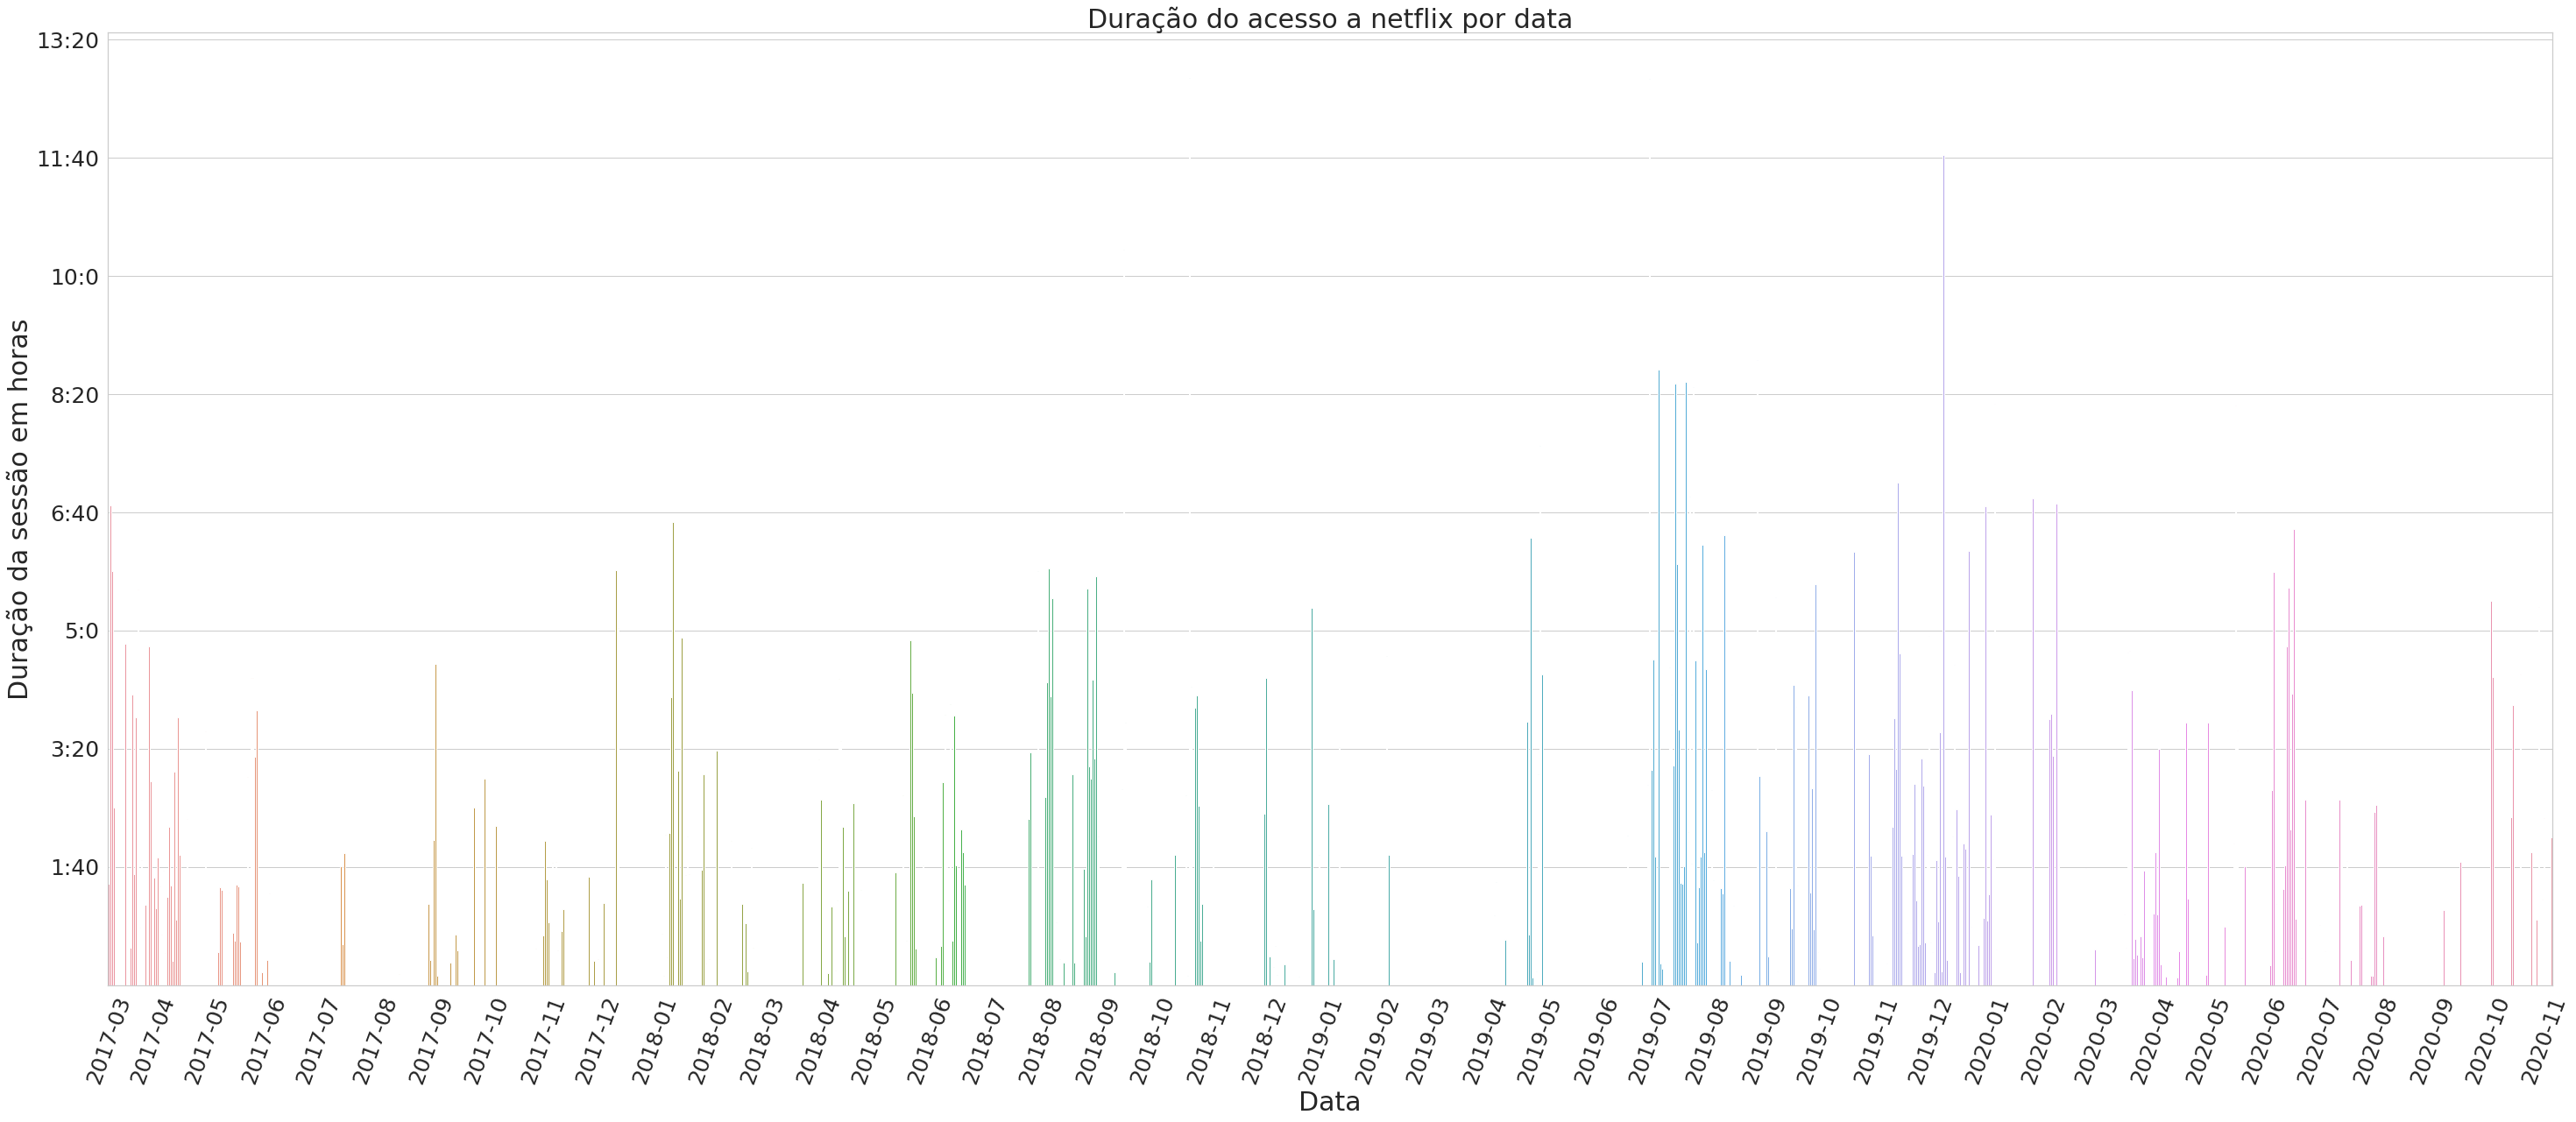

In [58]:
figure = plt.figure(figsize=(50,20))
sns.barplot(x='index', y = 'Duration', data=dt)
plt.xticks(index_labels, dt.loc[index_labels, 'index'].dt.to_period('M'),
           rotation = 70, fontsize= 25)
plt.yticks(y, ylabels, fontsize= 25)
plt.xlabel('Data', fontsize= 30)
plt.ylabel('Duração da sessão em horas', fontsize= 30)
plt.title('Duração do acesso a netflix por data', fontsize= 30)
plt.show()

### Duração média de acesso

In [59]:
print('A duração média de acesso é de {} horas e {} minutos. '.format(int(dt['Duration'].mean()/60), int(dt['Duration'].mean()%60)))

A duração média de acesso é de 0 horas e 41 minutos. 


### Variação da duração dos acessos de acordo com os dias da semana

In [60]:
by_weekday = dt.groupby('Weekday').mean()

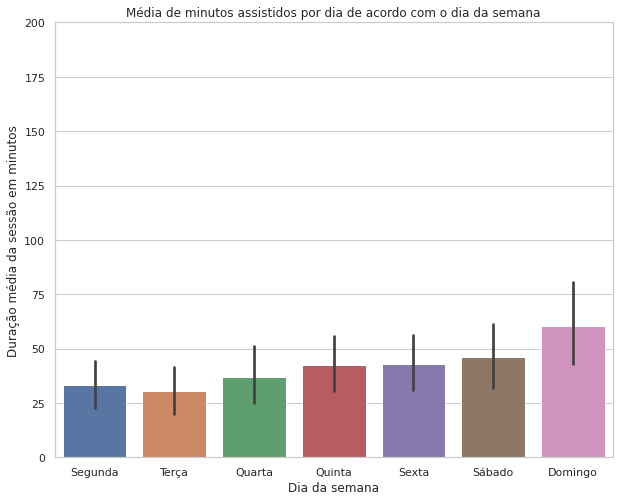

In [61]:
fig = plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.barplot( x='Weekday', y='Duration', data = dt)
plt.ylim(0, 200)
labels = list(map(weekdays.get, by_weekday.index))
plt.xticks(ticks=by_weekday.index , labels=labels)
plt.xlabel('Dia da semana')
plt.ylabel('Duração média da sessão em minutos')
plt.title('Média de minutos assistidos por dia de acordo com o dia da semana')
plt.show()

### Horários de acesso de acordo com a data

Cada acesso é composta por uma data, horário de início, duração e horário de fim. 

Acessos que iniciam em um dia e terminam em outro foram divididos em dois, um para cada dia, terminando o primeiro as 23:59 e iniciando o segundo as 00:00.

In [62]:
data_plot_time = outras_series[['Date', 'Start Time', 'End Time']].copy()
data_plot_time['Date End'] = data_plot_time['End Time'].dt.date
data_plot_time['Minute Start'] = (data_plot_time
                                  .apply(lambda x: x['Start Time'].hour*60 + 
                                         x['Start Time'].minute, axis=1))
data_plot_time['Minute End'] = (data_plot_time
                                  .apply(lambda x: x['End Time'].hour*60 + 
                                         x['End Time'].minute, axis=1))

data_plot_time.drop(['Start Time', 'End Time'], axis=1, inplace=True)

def atualiza_datas(x): 
  data_plot_time.loc[x.name] = [x['Date'], x['Date'], x['Minute Start'], 1439]
  data_plot_time.loc[data_plot_time.shape[0]+1] = [x['Date End'], x['Date End'], 0, x['Minute End']]

data_plot_time[data_plot_time['Minute Start'] > data_plot_time['Minute End']].apply(lambda x: atualiza_datas(x), axis=1)

data_plot_time.drop(data_plot_time[data_plot_time['Minute Start'] == data_plot_time['Minute End']].index, inplace=True)
data_plot_time = data_plot_time.sort_values(by=['Date', 'Minute Start', 'Minute End']).reset_index(drop=True)
data_plot_time['Duration'] = data_plot_time['Minute End'] - data_plot_time['Minute Start']
data_plot_time

,Date,Date End,Minute Start,Minute End,Duration
0,2017-03-08,2017-03-08,1295,1339,44
1,2017-03-08,2017-03-08,1339,1381,42
2,2017-03-09,2017-03-09,603,621,18
3,2017-03-09,2017-03-09,623,640,17
4,2017-03-09,2017-03-09,651,665,14
...,...,...,...,...,...
1857,2020-11-01,2020-11-01,1210,1234,24
1858,2020-11-01,2020-11-01,1235,1258,23
1859,2020-11-05,2020-11-05,1172,1201,29
1860,2020-11-05,2020-11-05,1201,1209,8


Formatando os labels para plotagem

In [63]:
y = [200,400,600,1000,1200, 1400]
horas = [str(int(x/60)) for x in y]
minutos = [str(int(x%60)) for x in y]
ylabels = list(zip(horas, minutos))
ylabels = [hora[0]+':'+hora[1] for hora in ylabels]

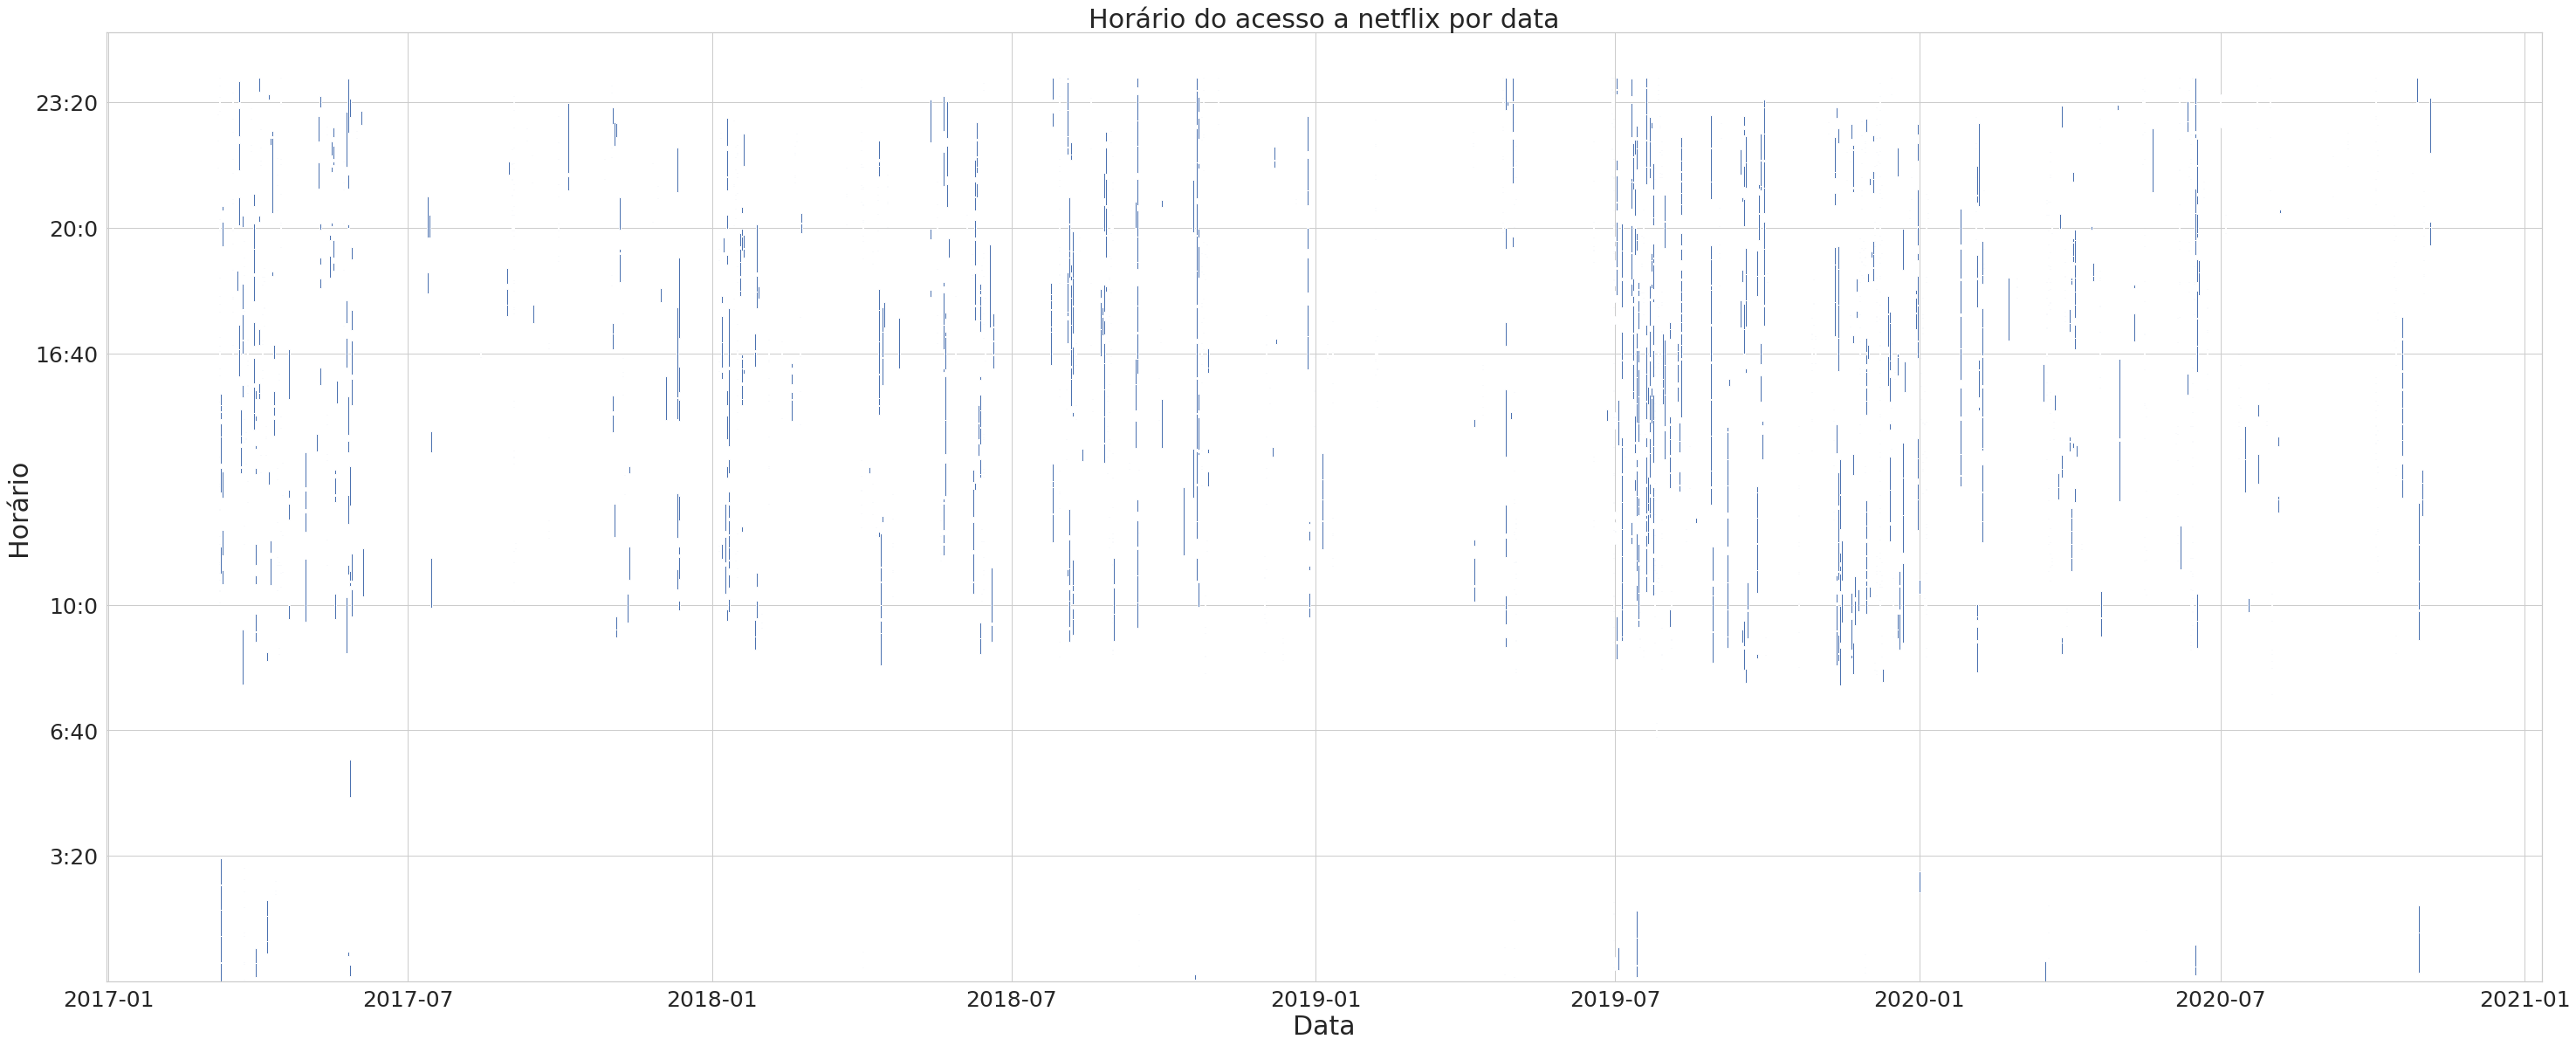

In [64]:
fig = plt.figure(figsize=(50,20))
plt.bar(x = data_plot_time['Date'], 
        height = data_plot_time['Duration'], 
        bottom = data_plot_time['Minute Start'] )
plt.yticks(y, ylabels , fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel('Data', fontsize=30)
plt.ylabel('Horário', fontsize=30)
plt.title('Horário do acesso a netflix por data', fontsize=30)
plt.show()

### Rankeando Séries

In [65]:
series_by_hour = outras_series.groupby(['Titulo']).sum()['Duration'].sort_values(ascending=False).head(10)

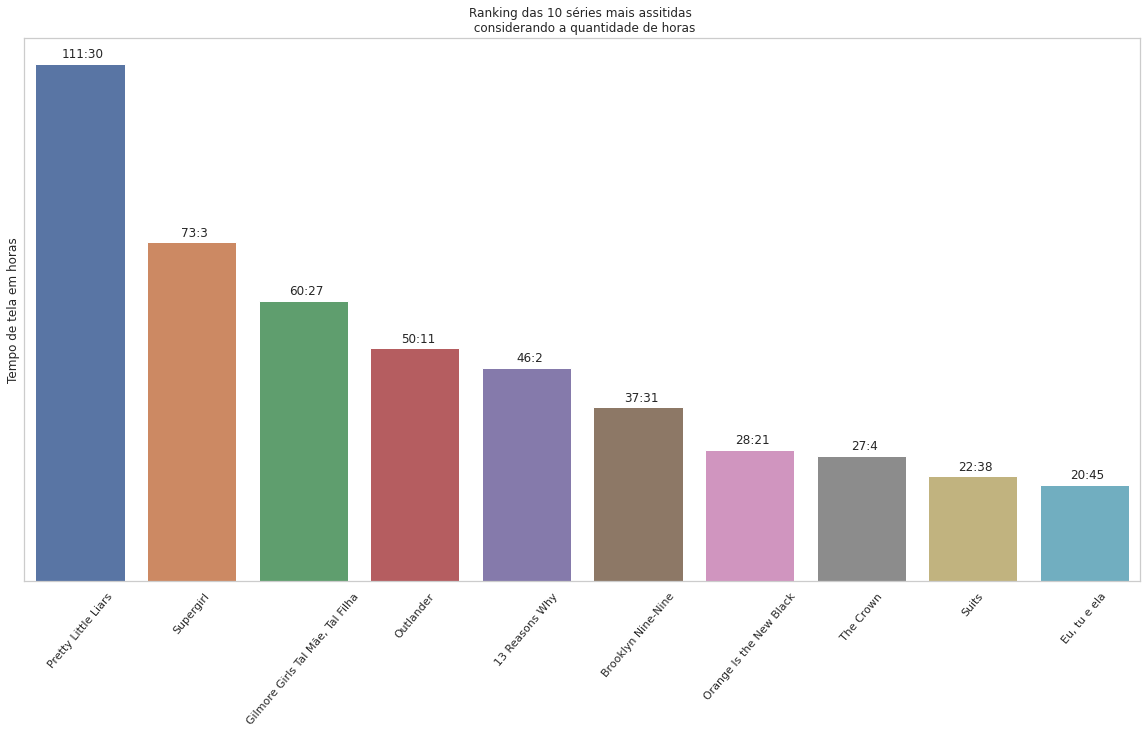

In [66]:
fig = plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
bars = sns.barplot( x=series_by_hour.index, y=series_by_hour.values)
plt.xticks(rotation = 50)
plt.yticks([],[])
plt.xlabel('')
plt.ylabel('Tempo de tela em horas')
plt.title('Ranking das 10 séries mais assitidas \n considerando a quantidade de horas')

for bar in bars.patches:
  height = bar.get_height()
  plt.annotate('{}:{}'.format(int(height/60), int(height%60)),
              xy=(bar.get_x() + bar.get_width() / 2, height),
              xytext=(3, 3),
              textcoords="offset points",
              ha='center', va='bottom')

plt.show()